In [2]:
import streamlit as st
import pandas as pd
import shap
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn import datasets
from sklearn.ensemble import RandomForestRegressor


#preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer

#metrics
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error

#algorithms 
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

#hyptertuning
from sklearn.model_selection import RandomizedSearchCV

#Scalers 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

In [38]:
# load JS visualization code to notebook
shap.initjs()

In [3]:
df = pd.read_csv('final_water.csv', index_col = 0)
#df = df.set_index('new_date')

ParserError: Error tokenizing data. C error: Expected 1 fields in line 32, saw 3


In [4]:
#Preprocessing 
knnimputer = KNNImputer(n_neighbors=2)
ohe = OneHotEncoder(handle_unknown='ignore')
scaler_rob = RobustScaler()

#StandardScaler worked best before but try RobustScaler 
knn_impute_scale1 = make_pipeline(knnimputer, scaler_rob)

In [5]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(df.drop(labels = 'tn', axis = 1), df['tn'], test_size = 0.3, random_state = 0)
X_train.shape, X_test.shape

((11863, 27), (5085, 27))

In [6]:
#Select top 10 feature importance
X_train = X_train.loc[:,['areaacres', 'lc_52', 'lc_81', 'lc_82', 'lc_90', 'lc_95', 'week',
       'airtemp_narr',  'precip24_narr', 'precip48_narr',
       'of_dist']]

X_test = X_test.loc[:,['areaacres', 'lc_52', 'lc_81', 'lc_82', 'lc_90', 'lc_95', 'week',
       'airtemp_narr',  'precip24_narr', 'precip48_narr',
       'of_dist']]

In [7]:
#robust scaler column transformer top 10 
ct = make_column_transformer(
    (knn_impute_scale1, ['areaacres', 'lc_52', 'lc_81', 'lc_82', 'lc_90', 'lc_95', 'week',
       'airtemp_narr',  'precip24_narr', 'precip48_narr',
       'of_dist']),
    remainder='passthrough')

{'randomforestregressor__n_estimators': 250, 'randomforestregressor__max_samples': 950, 'randomforestregressor__max_depth': 450}

{'xgbregressor__n_estimators': 950, 'xgbregressor__max_samples': 630, 'xgbregressor__max_depth': 870}

In [12]:
#Pipeline Creation 
rf = RandomForestRegressor(random_state = 0, n_jobs = -1, n_estimators = 250, max_samples = 950,
                          max_depth = 450)
xgb = xgb.XGBRegressor(random_state = 0, n_jobs = -1, n_estimators = 950, max_samples = 630,
                      max_depth = 870)
pipeline = make_pipeline(ct, rf)
pipeline1 = make_pipeline(ct,xgb)

In [13]:
#pipeline fitting Robust Scaler
pipeline.fit(X_train, y_train);

In [14]:
#pipeline fitting Robust Scaler
pipeline1.fit(X_train, y_train);

[23:06:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { max_samples } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [15]:
# Explaining the model's predictions using SHAP values
explainer = shap.TreeExplainer(pipeline['randomforestregressor'])
shap_values = explainer.shap_values(X_train)

In [32]:
pd.DataFrame(shap_values)

,0,1,2,3,4,5,6,7,8,9,10
0,-0.618942,0.496436,0.133148,-0.336031,0.014052,0.025688,0.429058,0.225274,1.346807,1.140422,14.315825
1,-0.590464,0.612845,0.155990,-0.567187,0.035012,-0.025271,0.382676,0.170626,-0.445383,-0.388287,12.084943
2,-0.522989,0.584403,0.094728,-0.562788,0.902352,-0.043585,0.395369,0.156811,-0.446839,-0.394310,12.587536
3,-0.598835,0.528231,0.144473,-0.396982,0.001422,-0.022031,0.429827,0.201502,0.008051,1.172888,13.436906
4,-0.609698,0.609664,0.166032,-0.486096,0.935517,-0.052948,0.427468,0.234201,-0.200117,1.191857,14.639642
...,...,...,...,...,...,...,...,...,...,...,...
11858,-0.582593,0.565660,0.175482,-0.507123,0.053846,-0.018914,0.390729,0.215539,0.319980,0.413838,13.638369
11859,-0.622378,0.569138,0.176898,-0.450837,0.029204,-0.024619,0.429261,0.246315,1.216012,1.160767,15.075404
11860,-0.561040,0.505570,0.144110,-0.439340,0.275722,-0.025400,0.396156,0.205159,-0.469420,0.635449,12.841979
11861,-0.548275,0.519476,0.109501,-0.606568,-0.003001,-0.040481,0.384892,0.160004,-0.489177,-0.401781,11.629285


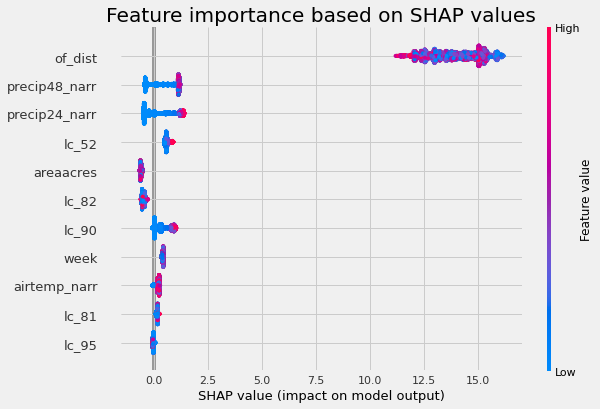

In [39]:
plt.title('Feature importance based on SHAP values')
shap.summary_plot(shap_values, X_train)

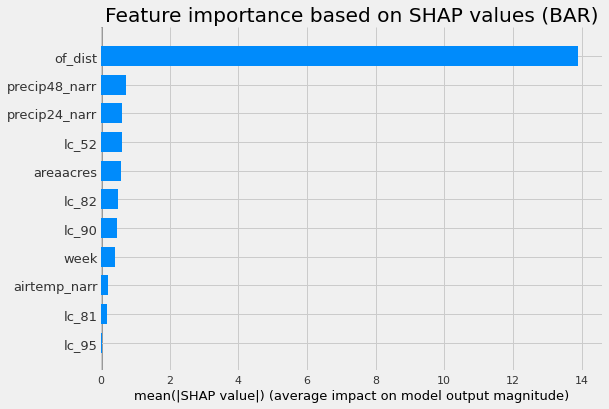

In [40]:
plt.title('Feature importance based on SHAP values (BAR)')
shap.summary_plot(shap_values, X_train, plot_type = 'bar')

In [41]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

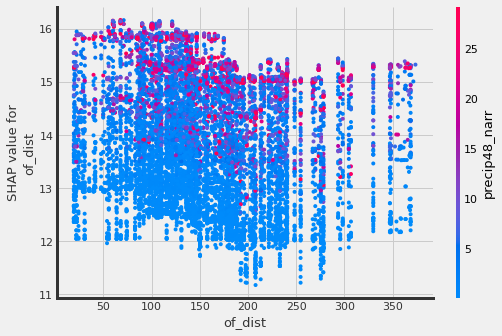

In [18]:
#create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('of_dist', shap_values, X_train)

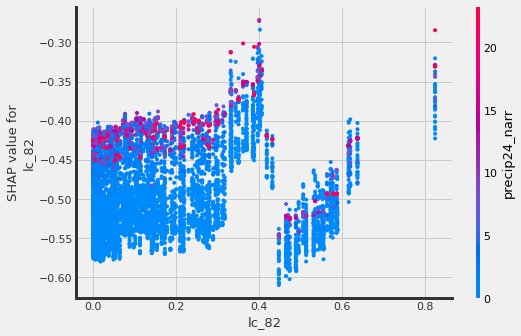

In [19]:
#create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('lc_82', shap_values, X_train)

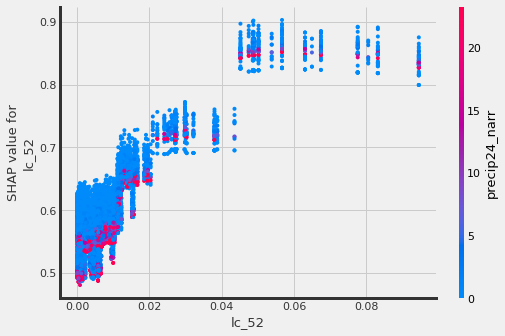

In [20]:
shap.dependence_plot('lc_52', shap_values, X_train)

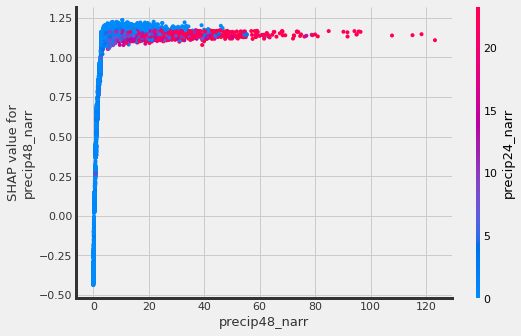

In [21]:
shap.dependence_plot('precip48_narr', shap_values, X_train)

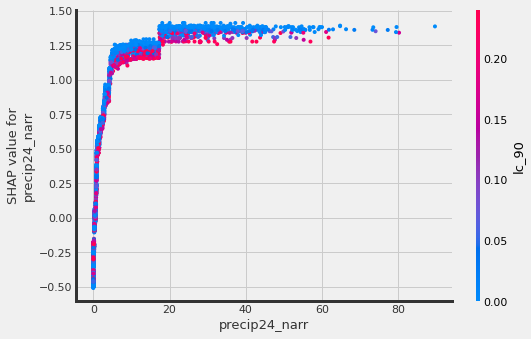

In [22]:
shap.dependence_plot('precip24_narr', shap_values, X_train)

In [23]:
# Explaining the model's predictions using SHAP values
explainer2 = shap.TreeExplainer(pipeline1['xgbregressor'])
shap_values2 = explainer2.shap_values(X_train)

In [34]:
pd.DataFrame(shap_values2)

,0,1,2,3,4,5,6,7,8,9,10
0,-0.332133,3.555872,-0.139247,-0.132134,-0.230377,-0.453856,0.056350,-0.333846,2.878969,-0.157369,15.498752
1,-0.474727,1.848533,-0.129237,-0.432980,-0.095760,-0.814628,-0.414058,-0.783633,-2.628672,0.108141,10.694925
2,-0.461537,1.860850,-0.136713,-0.163840,-0.146249,-0.815282,-0.612524,-0.790573,-2.627917,0.204035,10.567654
3,0.460094,2.496167,-0.122930,-0.231607,-0.138844,-0.809914,-0.103049,-0.329989,0.647681,-0.145358,13.494952
4,0.457728,2.669269,-0.128201,-0.326714,-0.171176,-0.809226,-0.053636,-0.333571,0.931388,-0.121285,13.849823
...,...,...,...,...,...,...,...,...,...,...,...
11858,0.552002,2.667254,-0.081612,-0.392073,-0.195758,-0.738950,-0.478827,-0.321538,0.554357,0.169360,13.871049
11859,-0.333319,3.405944,-0.091549,-0.299699,-0.283130,-0.449033,0.055698,-0.329939,2.930294,-0.141806,15.790415
11860,0.071889,1.583619,-0.137160,-0.311500,-0.068853,-0.951444,-0.394325,-0.769086,-2.839969,-0.395630,10.125898
11861,-0.461480,1.830924,-0.131639,-0.345789,-0.045353,-0.815464,-0.609359,-0.786882,-2.628982,0.201601,10.670322


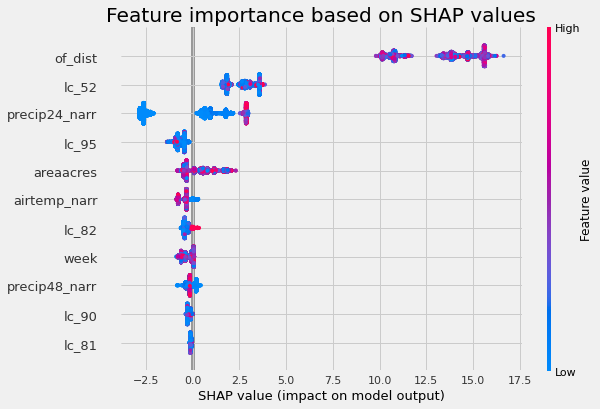

In [24]:
plt.title('Feature importance based on SHAP values')
shap.summary_plot(shap_values2, X_train)

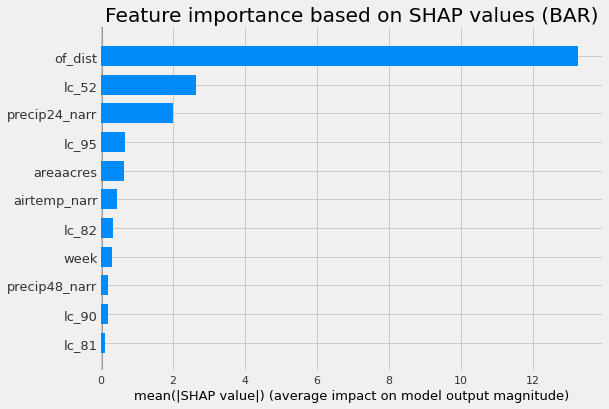

In [25]:
plt.title('Feature importance based on SHAP values (BAR)')
shap.summary_plot(shap_values2, X_train, plot_type = 'bar')

In [37]:
shap.force_plot(explainer2.expected_value, shap_values2[0,:], X_train.iloc[0,:])

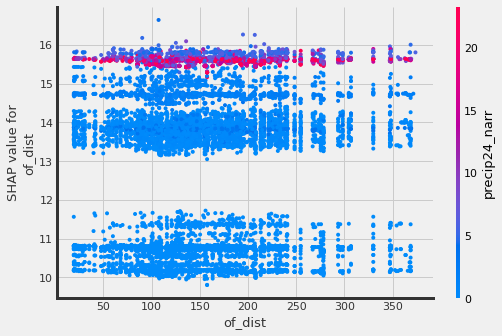

In [26]:
#create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('of_dist', shap_values2, X_train)

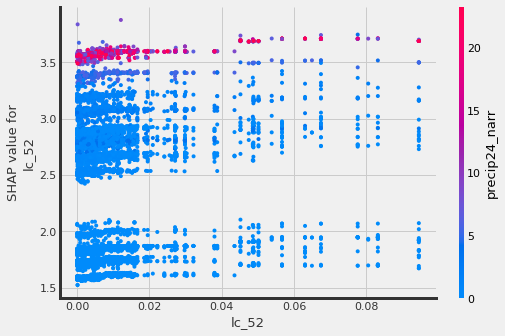

In [27]:
shap.dependence_plot('lc_52', shap_values2, X_train)

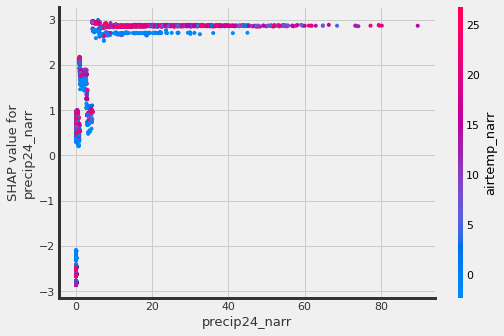

In [28]:
shap.dependence_plot('precip24_narr', shap_values2, X_train)

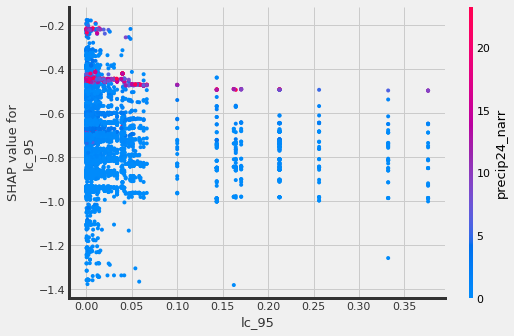

In [29]:
shap.dependence_plot('lc_95', shap_values2, X_train)

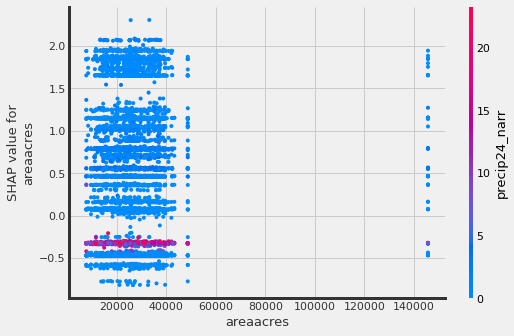

In [30]:
shap.dependence_plot('areaacres', shap_values2, X_train)